## Importing packages and data

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8

import os
import click
import copy
import numpy as np

import torch
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import anndata
import plotnine as p9

import scvi
from scvi.external import CondSCVI, DestVI
from destvi_spatial import DestVISpatial
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

scvi.settings.reset_logging_handler()
import logging
from utils import get_mean_normal, find_location_index_cell_type, metrics_vector, discrete_histogram

logger = logging.getLogger("scvi")


def construct_neighboors(adata, n_neighbors=5):
    locs = adata.obsm["locations"]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(locs)
    idx_to_neighs = nbrs.kneighbors(locs)[1][:, 1:]
    n_indices_ = torch.tensor(idx_to_neighs)
    X = torch.tensor(st_adata.X.todense())
    X_neigh = X[n_indices_]
    return X_neigh.numpy(), n_indices_.numpy()


def construct_spatial_partition(adata, n_cv=5):
    locs = adata.obsm["locations"]
    clust = KMeans(n_clusters=n_cv, n_init=100)
    attribs = clust.fit_predict(locs)
    return attribs


WORKING_DIR = "/data/yosef2/users/pierreboyeau/scvi-tools/simulations_code"
input_dir = os.path.join(WORKING_DIR, "out/")
# output_suffix = os.path.join(WORKING_DIR, "destvi")
# WORKING_DIR  = "/data/yosef2/users/pierreboyeau/scvi-tools/simulations_code"
# input_dir = "out/"
output_suffix = "destvi"
sc_epochs = 250
st_epochs = 250
amortization = "latent"

sc_adata = sc.read_h5ad(input_dir + "sc_simu.h5ad")
st_adata = sc.read_h5ad(input_dir + "st_simu.h5ad")

logger.info("Running DestVI")

# path management
output_dir = input_dir + output_suffix + "_" + amortization + "/"

if not os.path.isdir(output_dir):
    logger.info("Directory doesn't exist, creating it")
    os.mkdir(output_dir)
else:
    logger.info(f"Found directory at:{output_dir}")


def get_proportions_df(mdl):
    proportions = mdl.get_proportions(dataset=st_adata)
    proportions = pd.DataFrame(proportions).assign(spot=np.arange(1600))
    props_all = (
        proportions
        .rename(
            columns={
                0: "ct0",
                1: "ct1",
                2: "ct2",
                3: "ct3",
                4: "ct4",
            }
        )
    )
    props_all = (
        props_all
        .set_index(["spot"])
        .stack()
        .to_frame("proportion")
        .reset_index()
        .rename(columns={"level_1": "celltype"})
    )
    return props_all


def destvi_get_metrics(spatial_model):
    nb_sub_ct = 1
    # second get the proportion estimates
    proportions = spatial_model.get_proportions(dataset=st_adata).values
    agg_prop_estimates = proportions[:, ::nb_sub_ct]
    for i in range(1, nb_sub_ct):
        agg_prop_estimates += proportions[:, i::nb_sub_ct]

    # third impute at required locations
    # for each cell type, query the model at certain locations and compare to groundtruth
    # create a global flush for comparaison across cell types
    imputed_expression = np.zeros_like(s_groundtruth)
    for ct in range(C):
        indices, _ = find_location_index_cell_type(st_adata.obsm["locations"], ct, 
                                            s_location, s_ct)
        n_location = indices.shape[0]
        ind_x = indices[:, np.newaxis].astype(np.long)
        x = st_adata.X[ind_x[:, 0]].A
        if nb_sub_ct == 1:
            y = ct * np.ones(shape=(n_location, 1), dtype=np.long)
            expression = spatial_model.get_scale_for_ct(x, ind_x, y)
        else:
            # hierarchical clusters in Stereoscope
            partial_cell_type = proportions[ind_x[:, 0], nb_sub_ct*ct:nb_sub_ct*ct+nb_sub_ct] 
            partial_cell_type /= np.sum(partial_cell_type, axis=1)[:, np.newaxis] # shape (cells, nb_sub_ct)
            expression = np.zeros(shape=(ind_x.shape[0], x.shape[-1]))
            for t in range(nb_sub_ct):
                y = t * np.ones(shape=(n_location, 1), dtype=np.long) + nb_sub_ct * ct
                expression += partial_cell_type[:, [t]] * spatial_model.get_scale_for_ct(x, ind_x, y)

        normalized_expression = expression / np.sum(expression, axis=1)[:, np.newaxis]
        # flush to global
        indices_gt = np.where(s_ct == ct)[0]
        imputed_expression[indices_gt] = normalized_expression
    
    # score these predictions against GT
    all_res = []
    all_res_long = []
    for ct in range(C):
        # get local scores
        indices_gt = np.where(s_ct == ct)[0]
        # potentially filter genes for local scores only
        gene_list = np.unique(np.hstack([np.where(components_[ct, i] != 0)[0] for i in range(D)]))
        res = metrics_vector(s_groundtruth[indices_gt], imputed_expression[indices_gt], scaling=2e5, feature_shortlist=gene_list)
        res_long = metrics_vector(s_groundtruth[indices_gt], imputed_expression[indices_gt], scaling=2e5)
        all_res.append(pd.Series(res))
        all_res_long.append(pd.Series(res_long))

    all_res.append(pd.Series(metrics_vector(s_groundtruth, imputed_expression, scaling=2e5)))
    all_res = all_res + all_res_long
    df = pd.concat(all_res, axis=1)
    prop_score = metrics_vector(st_adata.obsm["cell_type"], agg_prop_estimates)
    df = pd.concat([df, pd.Series(prop_score)], axis=1)
    df.columns = ["ct" + str(i) for i in range(5)] + ["ct_long" + str(i) for i in range(5)] + ["allct", "proportions"]    
    
    return df.T.reset_index().rename(columns=dict(index="where_ct"))

## Training single-cell model & gathering spot neighborhood information

In [2]:
# setup ann data
scvi.data.setup_anndata(sc_adata, labels_key="cell_type")
mapping = sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"]

# train sc-model
sc_model = CondSCVI(sc_adata, n_latent=4, n_layers=2, n_hidden=128)
sc_model.train(
    max_epochs=sc_epochs,
    plan_kwargs={"n_epochs_kl_warmup": 2},
    progress_bar_refresh_rate=1,
)
plt.plot(sc_model.history["elbo_train"], label="train")
plt.title("ELBO on train set over training epochs")
plt.legend()
plt.savefig(output_dir + "sc_model_training.png")
plt.clf()
logger.info(f"Last computed scELBO TRAIN: {sc_model.history['elbo_train'][-1]}")
_sc_model = copy.deepcopy(sc_model)

In [4]:
mean_vprior, var_vprior = sc_model.get_vamp_prior(sc_adata, p=100)
x_n, ind_n = construct_neighboors(st_adata, n_neighbors=5)
attribs = construct_spatial_partition(st_adata)
st_adata.obsm["x_n"] = x_n
st_adata.obsm["ind_n"] = ind_n
scvi.data.setup_anndata(st_adata)

mult_ = 1
amortizations = [
    "none",
    "latent",
    "proportion",
    "both",
]
amortization = "latent"

In [54]:
loc_df = pd.DataFrame(st_adata.obsm["locations"])
loc_df.columns = ["x", "y"]
loc_df = (
    loc_df
    .reset_index()
    .rename(columns={"index": "spot"})
)

gt_props = pd.DataFrame(st_adata.obsm["cell_type"])
gt_props.columns = ["ct0", "ct1", "ct2", "ct3", "ct4"]
gt_props = (
    gt_props
    .stack()
    .to_frame("proportion_gt")
    .reset_index()
    .rename(columns={"level_0": "spot", "level_1": "celltype"})
)


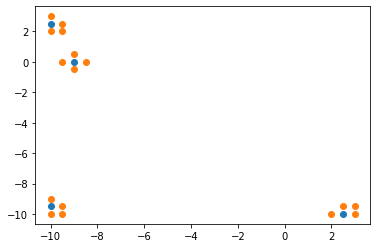

In [21]:
rdm_indices = [1, 25, 100, 1000]
plt.scatter(st_adata.obsm["locations"][rdm_indices, 0], st_adata.obsm["locations"][rdm_indices, 1])
n_locs = st_adata.obsm["locations"][st_adata.obsm["ind_n"][rdm_indices]].reshape(-1, 2)
plt.scatter(n_locs[:, 0], n_locs[:, 1])

## Step 0: get ground-truth

In [506]:
param_path = "/data/yosef2/users/pierreboyeau/data/spatial_data/"
PCA_path = param_path + "grtruth_PCA.npz"
grtruth_PCA = np.load(PCA_path)
mean_, components_ = grtruth_PCA["mean_"], grtruth_PCA["components_"]

C = components_.shape[0]
D = components_.shape[1]

threshold_gt = 0.4
spot_selection = np.where(st_adata.obsm["cell_type"].max(1) > threshold_gt)[0]
s_location = st_adata.obsm["locations"][spot_selection]
s_ct = st_adata.obsm["cell_type"][spot_selection, :].argmax(1)
s_gamma = st_adata.obsm["gamma"][spot_selection]
# get normal means
s_groundtruth = get_mean_normal(s_ct[:, None], s_gamma[:, None], mean_, components_)[:, 0, :]
s_groundtruth[s_groundtruth < 0] = 0
s_groundtruth = np.expm1(s_groundtruth)
s_groundtruth = s_groundtruth / np.sum(s_groundtruth, axis=1)[:, np.newaxis]

df = destvi_get_metrics(spatial_model_prior)
df.head()

## Step 1: estimate GT $\lambda$

### Grid search

In [ ]:
lamb_scales = np.geomspace(1e3, 1e9, 50)

WORKING_DIRB = os.path.join(WORKING_DIR, "mdl_ckpt")

gridsearch_res = pd.DataFrame()
gridsearch_metrics_res = pd.DataFrame()
for lamb in lamb_scales:
    for seed in range(3):
        for n_neig in [3, 5]:
            for mode in ["pair"]:
                save_feat = [lamb, n_neig, seed]
                save_feat = [str(sv) for sv in save_feat]
                savename = "_".join(save_feat) + "nn_step1_25pts.pt"
                mdl_path = os.path.join(WORKING_DIRB, savename)
                x_n, ind_n = construct_neighboors(st_adata, n_neighbors=n_neig)
                attribs = construct_spatial_partition(st_adata)
                st_adata.obsm["x_n"] = x_n
                st_adata.obsm["ind_n"] = ind_n
                scvi.data.setup_anndata(st_adata)
                print(x_n.shape)

                if os.path.exists(mdl_path):
                    print("Model exists ...")
                    spatial_model_prior = DestVISpatial.load(mdl_path, st_adata)
                else:
                    print("Model does not exists ...")
                    spatial_model_prior = DestVISpatial.from_rna_model(
                        st_adata,
                        _sc_model,
                        mean_vprior=mean_vprior,
                        var_vprior=mult_ * var_vprior,
                        amortization=amortization,
                        spatial_prior=True, 
                        spatial_agg=mode,
                        lamb=lamb,
                    )
                    spatial_model_prior.train(
                        max_epochs=2000,
                        train_size=1,
                        plan_kwargs=dict(
                            lr=1e-2, 
                            n_epochs_kl_warmup=400,
                        ),
                        progress_bar_refresh_rate=0,
                    )
                    spatial_model_prior.save(mdl_path)
                df = destvi_get_metrics(spatial_model_prior)
                props_all_metrics = (
                    df
                    .assign(
                        Model=mode,
                        lamb=lamb,
                        n_neig=n_neig,
                        seed=seed,
                    )
                )

                gridsearch_metrics_res = (
                    gridsearch_metrics_res.append(props_all_metrics, ignore_index=True)
                )


In [ ]:
spatial_model_gt = DestVISpatial.from_rna_model(
    st_adata,
    _sc_model,
    mean_vprior=mean_vprior,
    var_vprior=mult_ * var_vprior,
    amortization=amortization,
    spatial_prior=False,
)
spatial_model_gt.train(
    max_epochs=1000,
    train_size=1,
    plan_kwargs=dict(
        lr=1e-1, 
        n_epochs_kl_warmup=100,
    ),
    progress_bar_refresh_rate=1,
)


df = destvi_get_metrics(spatial_model_gt)
props_all_metrics = (
    df
    .assign(
        Model=mode,
        lamb=-np.infty,
        n_neig=n_neig,
    )
)
gridsearch_metrics_res = gridsearch_metrics_res.append(props_all_metrics, ignore_index=True)

In [1383]:
validation_gt_df = gridsearch_metrics_res.sort_values("lamb").copy()

## Step 2: Gene CV

### Prelim: Try to find gene modules

In [980]:
expression = sc_model.get_normalized_expression()

cts = sc_model.adata.obs["cell_type"]

scvi_model = SCVI(sc_adata, n_latent=2, n_layers=2, n_hidden=128)
scvi_model.train(
    max_epochs=sc_epochs,
    plan_kwargs={"n_epochs_kl_warmup": 2},
    progress_bar_refresh_rate=1,
)

latent = scvi_model.get_latent_representation()

latent_ = pd.DataFrame(latent)
latent_.index = ["cell" + str(col) for col in latent_.index]
expression_ = expression.T
expression_.columns = ["cell"+ str(col) for col in expression_.columns]

In [1090]:
import hotspot
hs = hotspot.Hotspot(expression_, model='none', latent=latent_)

hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_results = hs.compute_autocorrelations()

# hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes
hs_genes = hs_results.index
local_correlations = hs.compute_local_correlations(hs_genes, jobs=20) # jobs for parallelization

modules = hs.create_modules(
    min_gene_threshold=30, core_only=False, fdr_threshold=0.05
)

In [1110]:
gene_train_indices = (
    modules
    .groupby(modules)
    .apply(lambda x: x.sample(frac=0.5).index.to_series().astype(int))
    .to_frame("indices")
    .reset_index()
    .indices
    .values
)

gene_folds = np.isin(np.arange(ngenes), gene_train_indices)

nfolds = 2
ngenes = st_adata.X.shape[-1]
heldout_folds = np.arange(nfolds)

for heldout in heldout_folds[:-1]:
    training_mask = gene_folds != heldout
    training_mask = torch.tensor(training_mask)
    test_mask = ~training_mask
    print(training_mask.sum(), test_mask.sum())

### Grid search

In [1112]:
st_epochs = 500
cv_results = pd.DataFrame()
cv_results_metrics = pd.DataFrame()
# for heldout in heldout_folds:
for heldout in heldout_folds[:-1]:
    training_mask = gene_folds != heldout
    training_mask = torch.tensor(training_mask)
    test_mask = ~training_mask
    for lamb in lamb_scales:
        save_feat = [lamb, n_neig, heldout]
        save_feat = [str(sv) for sv in save_feat]
        savename = "_".join(save_feat) + "_step2_25pts_500___1epcs_stratified.pt"
        
        
        mdl_path = os.path.join(WORKING_DIRB, savename)
        if os.path.exists(mdl_path):
            spatial_model = DestVISpatial.load(mdl_path, st_adata)
            spatial_model.construct_loaders()
        else:
            spatial_model = DestVISpatial.from_rna_model(
                st_adata,
                _sc_model,
                mean_vprior=mean_vprior,
                var_vprior=mult_ * var_vprior,
                amortization=amortization,
                spatial_prior=True,
                spatial_agg="pair",
                lamb=lamb,
                training_mask=training_mask,
            )

            # Step 1: training genes
            spatial_model.train(
                max_epochs=1000,
                train_size=1,
                plan_kwargs=dict(
                    lr=1e-2, 
                    loss_mask=training_mask,
                    n_epochs_kl_warmup=400,
                ),
                progress_bar_refresh_rate=1,
            )

            pass_results = pd.DataFrame(spatial_model.history).assign(
                heldout=heldout,
                lamb=lamb,
                train_phase=True,
            )
            cv_results = cv_results.append(pass_results, ignore_index=True)

            # Step 2: heldout genes
            myparameters = [spatial_model.module.eta] + [spatial_model.module.beta]
            myparameters = filter(lambda p: p.requires_grad, myparameters)
            spatial_model.train(
                max_epochs=st_epochs,
                train_size=1,
                progress_bar_refresh_rate=1,
                plan_kwargs=dict(
                    lr=1e-2, 
                    loss_mask=test_mask, 
                    myparameters=myparameters,
                    n_epochs_kl_warmup=400,
                ),
            )
            spatial_model.save(mdl_path)
        pass_results = pd.DataFrame(spatial_model.history).assign(
            heldout=heldout,
            lamb=lamb,
            train_phase=False
        )
        cv_results = cv_results.append(pass_results, ignore_index=True)
        cv_results.to_pickle(os.path.join(WORKING_DIR, "spatial_cv.pickle"))
    
        rec_loss, rec_loss_all = spatial_model.get_metric()
        gene_infos = pd.DataFrame(
            {
                "gene": ["full"] + list(np.arange(len(rec_loss_all))),
                "reconstruction": [rec_loss] + list(rec_loss_all)
            }
        ).assign(
            heldout=heldout,
            lamb=lamb,
            train_phase=False
        )
        cv_results_metrics = cv_results_metrics.append(gene_infos, ignore_index=True)

    

## Step 3: Verifying properties

In [1391]:
plot_df_val = (
    validation_gt_df
    .assign(lambdd=lambda x: np.log10(x.lamb))
    .assign(lambdd=lambda x: x.lambdd.fillna(0.))
#     .loc[lambda x: x.Model == "pair"]
    .loc[lambda x: x.where_ct == "proportions"]
    .loc[lambda x: x.n_neig == 5]
    .groupby(["lambdd", "n_neig", "Model", "where_ct"])
    ["avg_spearman", "avg_pearson", "median_l1", "mse"]
    .mean()
    .reset_index()
)

plot_df_cv = (
    cv_results_metrics
    .loc[lambda x: x.gene != "full"]
    .assign(lambdd=lambda x: np.log10(x.lamb))
    .groupby("lambdd")
    .reconstruction
#     .median()
    .max()
    .reset_index()
)

/data/yosef2/users/pierreboyeau/conda/envs/spatial2/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [1392]:
met_name = "avg_spearman"
# orac_name = "reconstruction_loss_train"
orac_name = "reconstruction"
#     ["reconstruction_loss_train", "kl_local_train", "kl_global_train"]


In [1393]:
ref_met = plot_df_val.iloc[0][met_name]

In [1433]:
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False

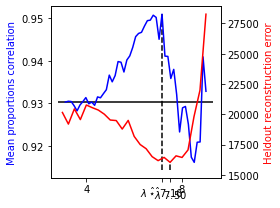

In [1437]:
fig, axes = plt.subplots(nrows=1, sharex=True, figsize=(4, 3))
plt.plot(
    plot_df_val.iloc[1:].lambdd, 
    plot_df_val.iloc[1:][met_name],
    c="blue"
)
lambdstar = plot_df_val.iloc[1:][met_name]
xmin, xmax = plt.xlim()
orac = plot_df_val.iloc[1:].set_index("lambdd")[met_name]
lambdstar = orac.idxmax()
corrmax = orac.max()
plt.hlines(ref_met, xmin, xmax, color="black")
plt.ylabel("Mean proportions correlation", c="blue")
ymin, ymax = plt.ylim()
plt.locator_params(axis='y', nbins=5)
plt.vlines(lambdstar, ymin, corrmax, color="black", linestyle="--")

plt.twinx()
plt.plot(plot_df_cv.lambdd, plot_df_cv[orac_name], c="red")
lambda_best = plot_df_cv.set_index("lambdd").reconstruction.idxmin()
reco_best = plot_df_cv.set_index("lambdd").reconstruction.min()
ymin, ymax = plt.ylim()
plt.vlines(lambda_best, ymin, reco_best, color="black", linestyle="--")
# plt.ylim(ymin, 25000)
# plt.ylim(ymin, 1800)
plt.ylabel("Heldout reconstruction error", c="red")
plt.xlabel("Prior strenght")
plt.locator_params(axis='y', nbins=6)

ticks = [4, 8, lambda_best, lambdstar]
labels = [
    4, 
    8, 
    "$\hat \lambda \approx$ {:.2f}".format(lambda_best),
    "$\lambda\^ \star \approx$ {:.2f}".format(lambdstar)
]
plt.xticks(ticks, labels)
# plt.xticks(list(plt.xticks()[0]) + [lambda_best])
plt.tight_layout()
plt.savefig("spatialprior.svg")